NAMA : Derajat Salim Wibowo
NIM  : 2210511077
Asal : UPN Veteran Jakarta - Teknik Informatika

In [65]:
#Memanggil Library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [66]:
# mengambil dataset dari Google Drive
df = pd.read_csv('/content/drive/MyDrive/ML/AMD(1980-11.07.2023).csv')

In [67]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-18,0.0,3.125000,2.937500,3.031250,3.031250,727200
1,1980-03-19,0.0,3.083333,3.020833,3.041667,3.041667,295200
2,1980-03-20,0.0,3.062500,3.010417,3.010417,3.010417,159600
3,1980-03-21,0.0,3.020833,2.906250,2.916667,2.916667,130800
4,1980-03-24,0.0,2.916667,2.635417,2.666667,2.666667,436800


In [68]:
#menampilkan jumlah sampel dataset
df.shape

(10919, 7)

In [69]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

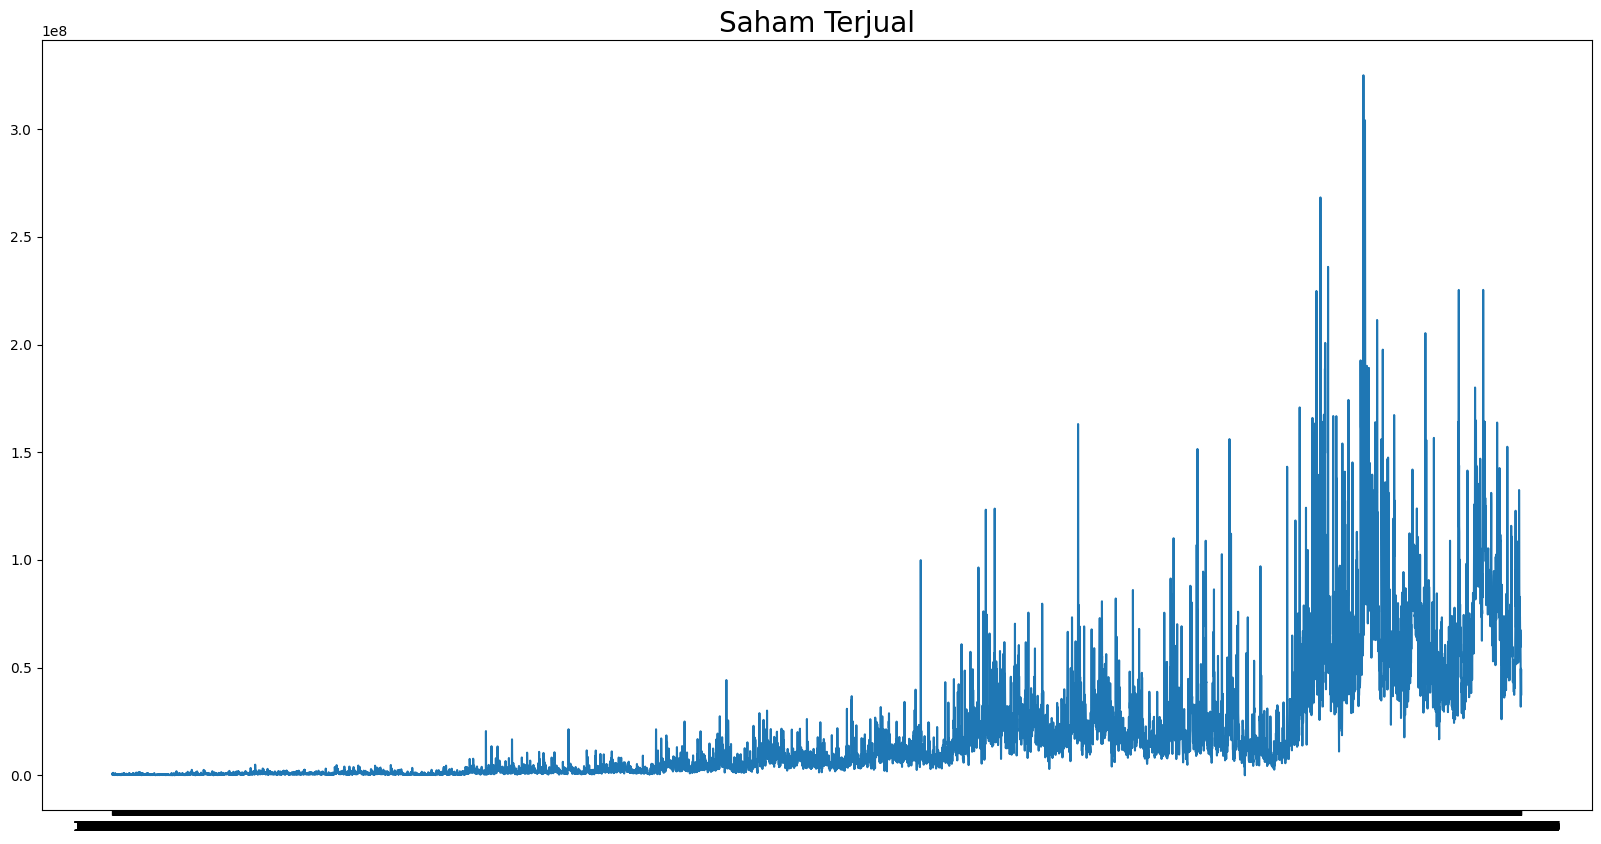

In [70]:
dates = df['Date'].values
volume = df['Volume'].values
plt.figure(figsize=(20, 10))
plt.plot(dates, volume)
plt.title('Saham Terjual', fontsize=20)
plt.show()

In [71]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [72]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Volume'].values.reshape(-1, 1))
scaled_data = scaled_data.flatten()

In [73]:
X_train, X_test = train_test_split(scaled_data, test_size=0.2, shuffle=False)
print(len(X_train), len(X_test))

8735 2184


In [74]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [75]:
train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set  = windowed_dataset(X_test, window_size=60, batch_size=32, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True, input_shape = [None, 1]),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [80]:
batas_mae = (scaled_data.max() - scaled_data.min()) * (10 / 100)

In [81]:
class callbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < batas_mae):
      print('MAE < 10% skala data')
      self.model.stop_training = True

callbacks = callbacks()

In [82]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics=['mae']
)

In [84]:
history = model.fit(
    train_set,
    epochs=30,
    validation_data=val_set,
    verbose=2,
    callbacks=[callbacks],
)

Epoch 1/30
MAE < 10% skala data
87/87 - 16s - loss: 8.9671e-04 - mae: 0.0231 - val_loss: 0.0225 - val_mae: 0.1756 - 16s/epoch - 180ms/step
